# Analyze RF mapping

In [3]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import scipy.stats as st
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from sklearn import svm
import time

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib notebook

In [4]:
#Set paths to experiment folders
main_path = [
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\2022-08-15_11-22-28_626791\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\2022-08-16_12-43-07_626791\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\2022-08-17_13-25-06_626791\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-19_13-48-26_628801\processed",
    #add AM noise to RF mapping
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-26_12-48-09_636397\processed", 
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-27_11-37-08_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-05_13-08-02_644547\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-06_12-35-35_644547\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\opto pilot\2022-11-07_12-31-20_635891\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\opto pilot\2022-11-08_11-03-58_635891\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2023-01-17_11-39-17_646318\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2023-01-18_10-44-55_646318\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\2023-01-23_11-50-37_636766\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\2023-01-24_11-59-07_636766\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\2023-01-25_12-48-26_636766\processed",
]


In [5]:
sel_session=14
session=Session(path=main_path[sel_session])

In [7]:
session.rf_trials

,Unnamed: 0,trialsX,trialsY,trialGratingOri,stimStartFrame,trialAMNoiseFreq,trialToneFreq,trialFullFieldContrast,trialStimType,stimStartTime,stimLatency
0,0,NaN,NaN,NaN,0,NaN,5000.0,NaN,sound,96.426708,0.036208
1,1,NaN,NaN,NaN,31,NaN,12000.0,NaN,sound,96.976309,0.069229
2,2,-798.722753,-438.722753,225.0,62,NaN,NaN,NaN,vis,97.446795,0.022615
3,3,NaN,NaN,NaN,93,NaN,11000.0,NaN,sound,98.006096,0.064896
4,4,798.722753,-146.240918,135.0,124,NaN,NaN,NaN,vis,98.481265,0.022505
...,...,...,...,...,...,...,...,...,...,...,...
1651,1651,-159.744551,438.722753,90.0,51181,NaN,NaN,NaN,vis,953.825640,0.022500
1652,1652,159.744551,-146.240918,135.0,51212,NaN,NaN,NaN,vis,954.342240,0.022340
1653,1653,-159.744551,-146.240918,135.0,51243,NaN,NaN,NaN,vis,954.876390,0.022340
1654,1654,NaN,NaN,NaN,51274,NaN,13000.0,NaN,sound,955.438223,0.067062


In [8]:
session.rf_trials.query('trialStimType == "sound"')

,Unnamed: 0,trialsX,trialsY,trialGratingOri,stimStartFrame,trialAMNoiseFreq,trialToneFreq,trialFullFieldContrast,trialStimType,stimStartTime,stimLatency
0,0,NaN,NaN,NaN,0,NaN,5000.0,NaN,sound,96.426708,0.036208
1,1,NaN,NaN,NaN,31,NaN,12000.0,NaN,sound,96.976309,0.069229
3,3,NaN,NaN,NaN,93,NaN,11000.0,NaN,sound,98.006096,0.064896
5,5,NaN,NaN,NaN,155,NaN,6000.0,NaN,sound,99.046097,0.070667
7,7,NaN,NaN,NaN,217,40.0,NaN,NaN,sound,100.076277,0.066687
...,...,...,...,...,...,...,...,...,...,...,...
1646,1646,NaN,NaN,NaN,51026,NaN,11000.0,NaN,sound,951.278141,0.060771
1647,1647,NaN,NaN,NaN,51057,0.0,NaN,NaN,sound,951.797891,0.063521
1649,1649,NaN,NaN,NaN,51119,12.0,NaN,NaN,sound,952.837877,0.068937
1650,1650,NaN,NaN,NaN,51150,NaN,15000.0,NaN,sound,953.348678,0.062958


In [9]:
session.rf_trials.groupby('trialToneFreq').count()

,Unnamed: 0,trialsX,trialsY,trialGratingOri,stimStartFrame,trialAMNoiseFreq,trialFullFieldContrast,trialStimType,stimStartTime,stimLatency
trialToneFreq,,,,,,,,,,
4000.0,24,0,0,0,24,0,0,24,24,24
5000.0,24,0,0,0,24,0,0,24,24,24
6000.0,24,0,0,0,24,0,0,24,24,24
7000.0,24,0,0,0,24,0,0,24,24,24
8000.0,24,0,0,0,24,0,0,24,24,24
9000.0,24,0,0,0,24,0,0,24,24,24
10000.0,24,0,0,0,24,0,0,24,24,24
11000.0,24,0,0,0,24,0,0,24,24,24
12000.0,24,0,0,0,24,0,0,24,24,24


In [10]:
rf_trials_sound=session.rf_trials.query('trialStimType == "sound"')

sound_ID=[]
sound_freq=[]

for tt,trial in rf_trials_sound.iterrows():
    if ~np.isnan(trial['trialAMNoiseFreq']):
        sound_string='AM '+str(int(trial['trialAMNoiseFreq']))+' Hz'
        freq=trial['trialAMNoiseFreq']
    elif ~np.isnan(trial['trialToneFreq']):
        sound_string='Tone '+str(int(trial['trialToneFreq']/1000))+' kHz'
        freq=trial['trialToneFreq']
    else:
        sound_string=''
    sound_ID.append(sound_string)
    sound_freq.append(freq)
    
rf_trials_sound['sound_ID']=sound_ID
rf_trials_sound['sound_freq']=sound_freq

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_27192\2524313588.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_trials_sound['sound_ID']=sound_ID
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_27192\2524313588.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_trials_sound['sound_freq']=sound_freq


In [11]:
# rf_trials_sound.groupby(['sound_ID','sound_freq']).count()
rf_trials_sound['sound_freq']
# rf_trials_sound

0        5000.0
1       12000.0
3       11000.0
5        6000.0
7          40.0
         ...   
1646    11000.0
1647        0.0
1649       12.0
1650    15000.0
1654    13000.0
Name: sound_freq, Length: 432, dtype: float64

In [12]:
# loop through sessions and make unit xarrays
time_before_flash = 0.25
trial_duration = 0.75
bin_size = 0.010


# Make tensor (3-D matrix [units,time,trials])
trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                              rf_trials_sound, time_before_flash, trial_duration, 
                                              bin_size)

# make xarray
session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                           coords={
                               "unit_id": session.good_units.index.values,
                               "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                               "trials": rf_trials_sound.index.values
                               })

In [13]:
session.trial_da.sel(unit_id=session.good_units.index[2]).values

array([[  0., 100.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 100., 100., ...,   0.,   0.,   0.],
       ...,
       [100., 100.,   0., ...,   0.,   0.,   0.],
       [  0., 100.,   0., ...,   0.,   0.,   0.],
       [  0., 100.,   0., ...,   0.,   0.,   0.]])

In [14]:
#make heatmaps

#Average & normalize responses of each unit to each stimulus

#find baseline mean and std per unit
baseline_mean_per_trial=session.trial_da.sel(time=slice(-0.25,-0.15)).mean(dim=["time"])
baseline_mean=baseline_mean_per_trial.mean(dim="trials").values
baseline_std=baseline_mean_per_trial.std(dim="trials").values

#find unique stimuli
stimuli = np.unique(sound_freq)

#pre-allocate array for average
unit_frs_by_stim = np.zeros((len(session.trial_da.unit_id),len(session.trial_da.time),len(stimuli)))

#normalize each unit's avg FRs to its baseline  FR
for ss,stim in enumerate(stimuli):
    stim_trials = rf_trials_sound.query('sound_freq == @stim').index.values
    unit_frs_by_stim[:,:,ss] = session.trial_da.sel(trials=stim_trials).mean(dim="trials").values
    
    # z-score each unit rel to its baseline
    unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T

#Find/define probe borders for plotting
probe_borders=np.where(session.good_units['probe'].iloc[:-1].values!=session.good_units['probe'].iloc[1:].values)[0]
all_edges=np.hstack([0,probe_borders,len(session.good_units)])
midpoints=all_edges[:-1]+(all_edges[1:]-all_edges[:-1])/2
probe_labels=session.good_units['probe'].iloc[midpoints.astype('int')].values


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_27192\3158155675.py:22: RuntimeWarning: divide by zero encountered in true_divide
  unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_27192\3158155675.py:22: RuntimeWarning: invalid value encountered in true_divide
  unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_27192\3158155675.py:22: RuntimeWarning: divide by zero encountered in true_divide
  unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_27192\3158155675.py:22: RuntimeWarning: invalid value encountered in true_divide
  unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_27192\3158155675.py:22: RuntimeWarning

In [15]:
# baseline_mean_per_trial.values

<IPython.core.display.Javascript object>


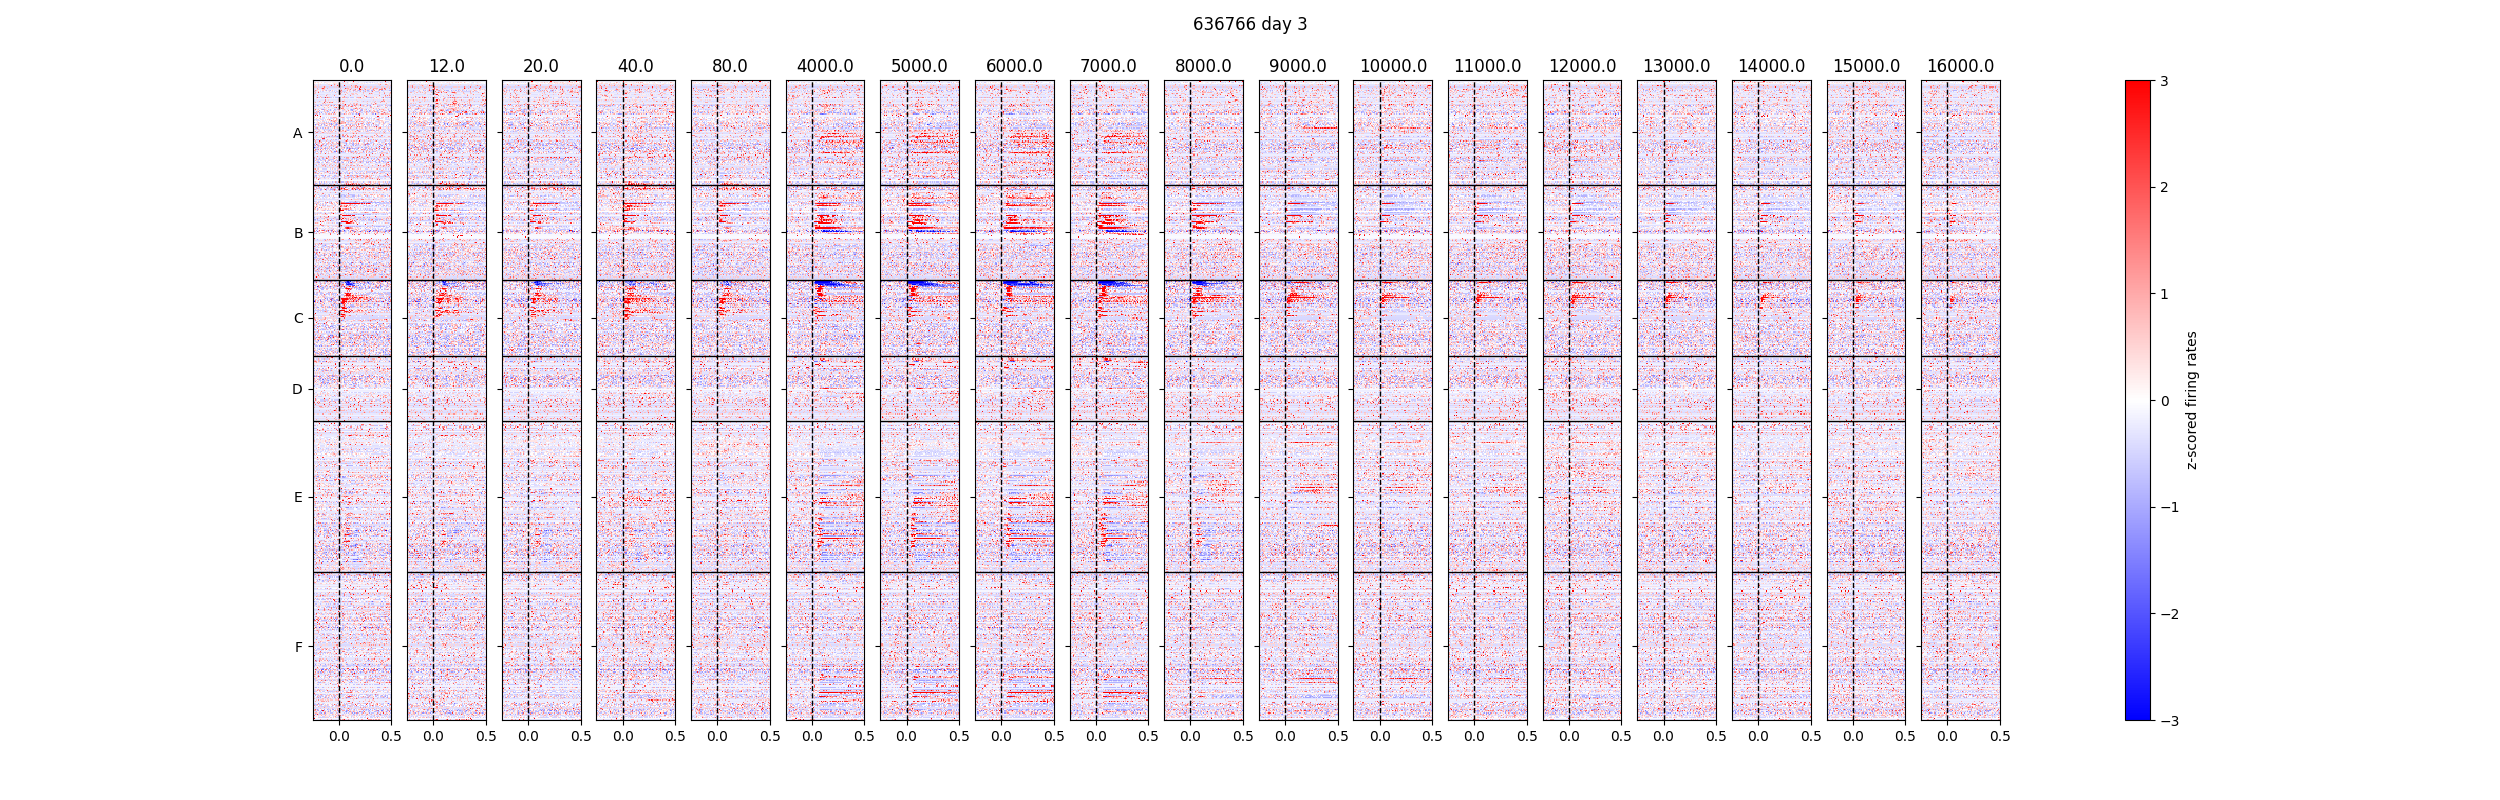

Text(0, 0.5, 'z-scored firing rates')

In [18]:
# plot heatmaps
# ordered by ascending channel number - top is tip of probe

fig,ax=plt.subplots(1,len(stimuli),figsize=(25,8))
for xx in range(0,len(stimuli)): 
    im = ax[xx].imshow(unit_frs_by_stim[:,:,xx],aspect='auto',vmin=-3,vmax=3,
                   cmap=plt.get_cmap('bwr'),interpolation='none',
                   extent=(-time_before_flash,trial_duration-time_before_flash,
                           0,unit_frs_by_stim.shape[0]))
    
    ax[xx].axvline(0,color='k',linestyle='--',linewidth=1)
    ax[xx].set_title(str(stimuli[xx]))
    ax[xx].set_xlim(-0.25,0.5)
    ax[xx].hlines(unit_frs_by_stim.shape[0]-probe_borders,xmin=-0.5,xmax=1.5,
                   color='k',linewidth=1)
    ax[xx].set_yticks(unit_frs_by_stim.shape[0]-midpoints)
    ax[xx].set_yticklabels(probe_labels)
    if xx>0:
        ax[xx].set_yticklabels([])

fig.suptitle('636766 day 3')
        
# this adjusts the other plots to make space for the colorbar
fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.3) 
cax = plt.axes([0.85, 0.1, 0.01, 0.8])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('z-scored firing rates')



In [17]:
# significantly affected units

pre_window=[-0.2,-0.1]
stim_window=[0.00,0.1]

unit_stim_pvals=np.zeros((len(session.good_units),len(session.trials.trialStimID.unique())))
unit_stim_pvals[:]=np.nan

stim_list=np.sort(session.trials.trialStimID.unique())

# loop over units
for u_count, (uid, unit) in enumerate(session.good_units.iterrows()):

    # loop over stimuli
    for ss,stim in enumerate(stim_list):
        
#         stim_list.append(stim)
        # test if significantly affected (100ms baseline vs. 100ms stimulus)
        stim_trials=session.trials.query('trialStimID == @stim').index
        pre_trial_da=session.trial_da.sel(trials=stim_trials, unit_id=uid,
                                          time=slice(pre_window[0],pre_window[1])).mean(dim='time')
        stim_trial_da=session.trial_da.sel(trials=stim_trials, unit_id=uid,
                                           time=slice(stim_window[0],stim_window[1])).mean(dim='time')
        if np.sum(stim_trial_da-pre_trial_da)!=0:
            h,p=st.wilcoxon(pre_trial_da,stim_trial_da,zero_method='wilcox')
        else:
            p=1
        
        unit_stim_pvals[u_count,ss]=p
        
# find N units affected by any sound stimulus vs. any vis stimulus (that's the denominator)

KeyError: "not all values found in index 'trials'"

In [ ]:
unit_stim_pvals

In [ ]:
np.sum(unit_stim_pvals<0.01,axis=0)

In [ ]:
stim_list

In [ ]:
np.sort(session.trials.trialStimID.unique())